# Sampling Borrowers from Historical User States

To avoid over-indexing on the exact debt distribution at the time of the simulation (i.e. the borrowers pulled from the subgraph), we resample debt positions from a Gaussian Kernel Density Estimator (KDE). A KDE provides a multi-variate, non-parametric probability density function (PDF). 

We randomly sample some pre-determined number of debt positions from this trained KDE, which provides us with a realistic borrower distribution for our simulations that more closely resembles the historical state of the crvUSD system compared to the exact distribution at the time we pull data from the subgraph.

In [1]:
from datetime import datetime
from src.configs import LLAMMA_WSTETH
import matplotlib.pyplot as plt
from scipy import stats
from src.sim.scenario import Scenario
from copy import deepcopy
from src.plotting.sim import plot_borrowers_2d, plot_borrowers_3d, plot_reserves
from src.utils import get_historical_user_snapshots

%load_ext autoreload
%autoreload 2

In [2]:
# Let's sample Q4 of 2023
start = int(datetime(2023, 10, 1).timestamp())
end = int(datetime(2024, 1, 1).timestamp())
market = LLAMMA_WSTETH

In [3]:
df = get_historical_user_snapshots(market, start, end)
df.head()

,user,collateral,depositedCollateral,collateralUp,loss,lossPct,stablecoin,n,n1,n2,debt,health,timestamp,collateral_log,debt_log
id,,,,,,,,,,,,,,,
0x37417b2238aa52d0dd2d6252d989e728e8f706e4-1696089600-0xff05bd3180bc8e38f7aea981fe2af57f277bd9df,0xff05bd3180bc8e38f7aea981fe2af57f277bd9df,1.190680,1.199174,1.190680,0.008494,0.708339,0,4,69,72,1110.846628,0.033859,1696089851,0.174524,7.012878
0x37417b2238aa52d0dd2d6252d989e728e8f706e4-1696089600-0xfde66fb9f020de05531534eae35c3785d75ad59c,0xfde66fb9f020de05531534eae35c3785d75ad59c,7.805002,7.805002,7.805002,0.000000,0.000000,0,4,71,74,7137.306973,0.033783,1696089851,2.054765,8.873091
0x37417b2238aa52d0dd2d6252d989e728e8f706e4-1696089600-0xfd81b27d9796a1ba7d7171ea70010c9befb2a62a,0xfd81b27d9796a1ba7d7171ea70010c9befb2a62a,127.251573,127.251573,127.251573,0.000000,0.000000,0,10,74,83,108602.582700,0.043226,1696089851,4.846166,11.595450
0x37417b2238aa52d0dd2d6252d989e728e8f706e4-1696089600-0xfccc0f1d9a3373aa031c7883ec8aca1e1dd35f3a,0xfccc0f1d9a3373aa031c7883ec8aca1e1dd35f3a,14.000000,14.152796,14.000000,0.152796,1.079616,0,4,64,67,13722.482649,0.034760,1696089851,2.639057,9.526791
0x37417b2238aa52d0dd2d6252d989e728e8f706e4-1696089600-0xfcba7b991c337e78f5f36d5b37f229630d9cacd4,0xfcba7b991c337e78f5f36d5b37f229630d9cacd4,17.997159,20.049146,17.997159,2.051987,10.234784,0,4,10,13,29547.439346,0.062726,1696089851,2.890214,10.293752


### Normality

Notice that both debt and collateral are log-normally distributed, so we may apply a Gaussian KDE on the log of debt and collateral to sample new debt positions.

The number of bands per position (N) is clearly a bi-modal distribution around N=4 and N=10. This is expected: N=4 provides the most leverage, and N=10 is the default. This, however, means our Gaussian KDE will be less performant in sampling N than sampling debt or collateral.

Text(0.5, 1.0, 'N Distribution')

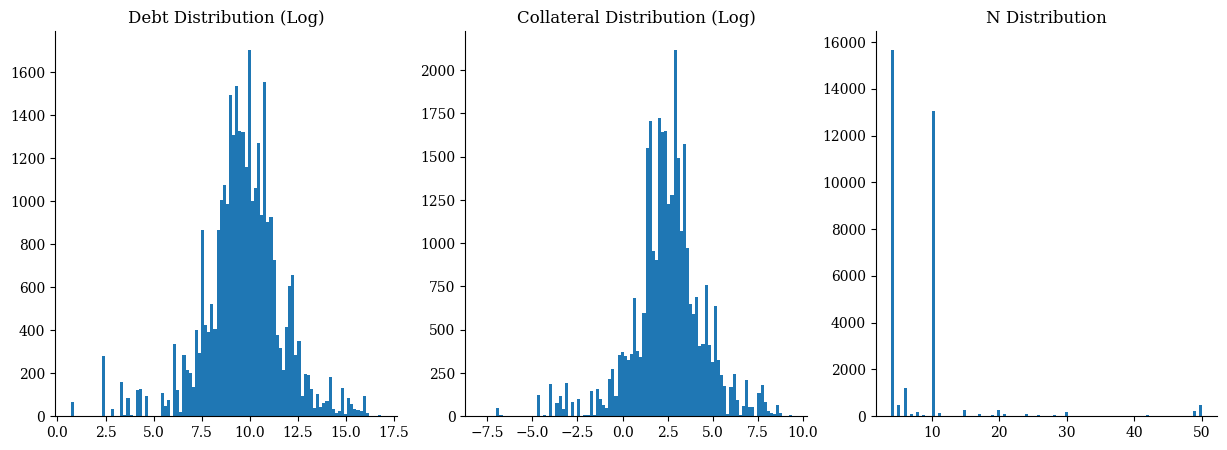

In [4]:
f, axs = plt.subplots(1, 3, figsize=(15, 5))
df["debt_log"].hist(bins=100, grid=False, ax=axs[0])
axs[0].set_title("Debt Distribution (Log)")
df["collateral_log"].hist(bins=100, grid=False, ax=axs[1])
axs[1].set_title("Collateral Distribution (Log)")
df["n"].hist(bins=100, grid=False, ax=axs[2])
axs[2].set_title("N Distribution")

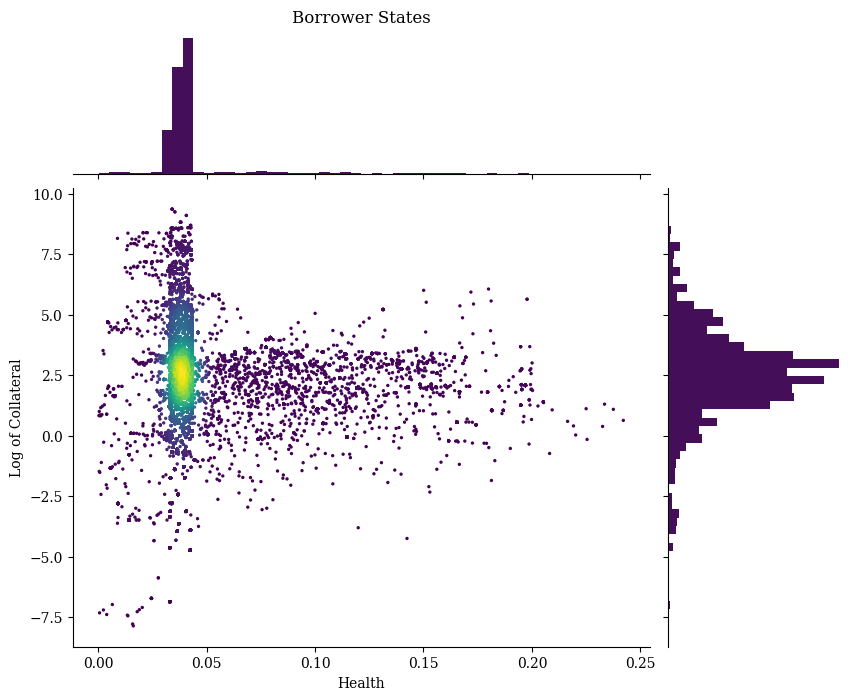

In [5]:
values = df[["health", "collateral_log"]].values.T
density = stats.gaussian_kde(values)(values)
fig = plot_borrowers_2d(*values, density)  # , xlim=(0.03, 0.05))

In [6]:
values = df[["health", "collateral_log", "n"]].values.T
density = stats.gaussian_kde(values)(values)
plot_borrowers_3d(*values, density)

# Randomly Sample Positions from KDE

Tried: KDE sampling health, collateral, and n, but it's not possible to quickly/accurately determine the corresponding debt required to arrive at that health because health is not a smooth/continuous/differentiable function.

New strategy: KDE sample debt, collateral, and n, and then check that health is reasonable. Plot the output and see if the generated positions are reasonable.

In [7]:
scenario_template = Scenario("baseline_macro", ["wsteth"])

[INFO][13:35:40][src.sim.scenario]-86784: Fetching wsteth market from subgraph
[INFO][13:35:43][src.sim.scenario]-86784: Market snapshot as 2024-01-12 13:25:35
[INFO][13:35:43][src.sim.scenario]-86784: Bands snapshot as 2024-01-11 19:00:23
[INFO][13:35:43][src.sim.scenario]-86784: Users snapshot as 2024-01-12 11:03:47
[INFO][13:35:51][src.sim.scenario]-86784: Using 245600 1Inch quotes from 2023-11-19 19:00:00 to 2023-12-19 19:00:00
[INFO][13:35:51][src.utils.poolgraph]-86784: Found 20 valid trading cycles of length 3.


### Plotting LLAMMA Reserves Without Resampling Debt Positions

[INFO][13:35:51][src.sim.scenario]-86784: Equilibrated prices with 4 arbitrages with total profit 996
[INFO][13:35:51][src.sim.scenario]-86784: Validating loaded positions in wstETH Controller.
[INFO][13:35:51][src.sim.scenario]-86784: Liquidating 0x2761a575cf6ea58d9d59426f1733df573d92cf36: with debt 1430340817882371929321383.
[INFO][13:35:51][src.sim.scenario]-86784: Liquidating 0x1df0096901d5bb51419ed2217fed7d17a5cb2fd7: with debt 107082693663651609046376.
[WARNING][13:35:51][src.sim.scenario]-86784: 4.54% of debt (2 positions) was incorrectly loaded with <0 health (1537423 crvUSD)


243
32352449.717820268


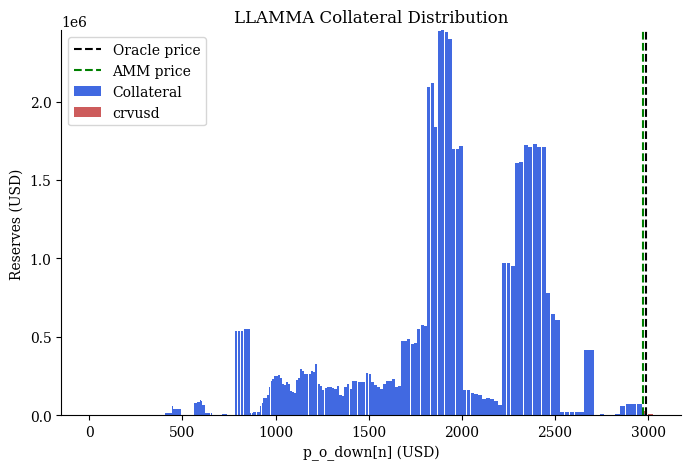

In [8]:
scenario_template_copy = deepcopy(scenario_template)
scenario_template_copy.prepare_for_run(resample_borrowers=False)
controller = scenario_template_copy.controllers[0]

print(controller.n_loans)
print(controller.total_debt() / 1e18)

_ = plot_reserves(controller.AMM)

[CRITICAL][13:50:21][src.sim.scenario]-86784: READING KDE FROM FILE.
[INFO][13:50:21][src.sim.scenario]-86784: Equilibrated prices with 4 arbitrages with total profit 66766
[INFO][13:50:21][src.sim.scenario]-86784: Validating loaded positions in wstETH Controller.
[INFO][13:50:21][src.sim.scenario]-86784: 0.00% of debt (0 positions) was incorrectly loaded with <0 health (0 crvUSD)


350
55577245.65029412


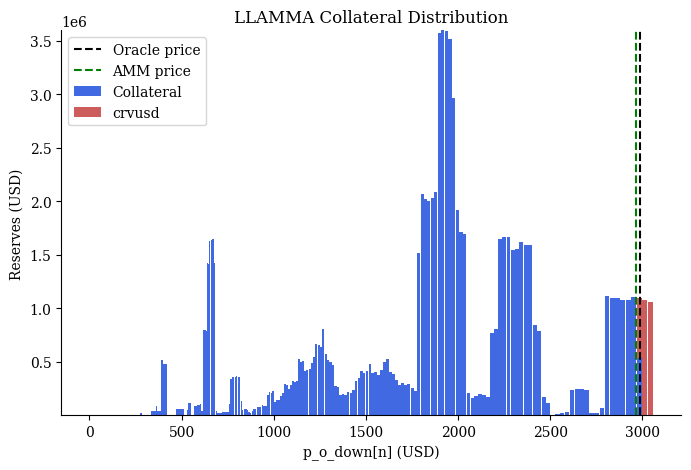

In [10]:
scenario = deepcopy(scenario_template)
controller = scenario.controllers[0]

scenario.prepare_for_run()

print(controller.n_loans)
print(controller.total_debt() / 1e18)

_ = plot_reserves(controller.AMM)